# Evaluation using the BeFree corpus 

### EUADR dataset
The EU-ADR dataset contains annotations on drugs, diseases, genes and proteins, and associations between them. In this study, we used only GDAs to evaluate the method. Each association is classified according to its level of certainty as positive association (PA), negative association (NA), speculative association (SA); or false association (FA). The EU-ADR corpus is based on 100 MEDLINE abstracts for each association set, and its annotation was conducted by three experts. 


#  -------------------------------------------------------------------------------------------

# imports

In [1]:
import tensorflow as tf
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras_tqdm import TQDMNotebookCallback
import numpy as np
from keras_tqdm import TQDMNotebookCallback
import nltk
import xml.etree.ElementTree as ET
import pandas as pd
import os
import string
from nltk.tokenize import TreebankWordTokenizer
from numpy.random import random_sample
import re
import pickle
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from keras.layers import Embedding, Flatten,LSTM,GRU
from keras.layers.convolutional import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation,  Input, merge,Conv1D,MaxPooling1D,GlobalMaxPooling1D,Convolution1D
from keras import regularizers
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from keras.layers import Concatenate, concatenate
from keras import backend as K
from keras.layers import multiply
from keras.layers import merge
from keras.layers.core import *
from keras.layers.recurrent import LSTM
from keras.models import *

Using TensorFlow backend.


###  Define Callback functions to generate Mesures

In [2]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


# Experiments to reproduce the results of Table 8 

### Load Prerocssed Data

In [3]:
with open('../data/pickles/befree_EUADR_2class_PubMed-and-PMC-w2v.pickle', 'rb') as handle:        
    
    W_train = pickle.load(handle)
    print("W_train",len(W_train))
    d1_train = pickle.load(handle)
    print("d1_train",len(d1_train))
    d2_train = pickle.load(handle)
    print("d2_train",len(d2_train))
    Y_train = pickle.load(handle)
    print("Y_train",len(d2_train))
    Tr_word_list = pickle.load(handle)
    print("Tr_word_list",len(d2_train))
    word_vectors = pickle.load(handle)
    print("word_vectors",len(word_vectors))
    word_dict = pickle.load(handle)
    print("word_dict",len(word_dict))
    d1_dict = pickle.load(handle)
    print("d1_dict",len(d1_dict))
    d2_dict = pickle.load(handle)
    print("d2_dict",len(d2_dict))
    label_dict = pickle.load(handle)
    print("label_dict",len(label_dict))
    MAX_SEQUENCE_LENGTH = pickle.load(handle)
    print("MAX_SEQUENCE_LENGTH",MAX_SEQUENCE_LENGTH)


W_train 355
d1_train 355
d2_train 355
Y_train 355
Tr_word_list 355
word_vectors 1355
word_dict 1355
d1_dict 169
d2_dict 171
label_dict 4
MAX_SEQUENCE_LENGTH 102


### Create Position Embedding Vectors

In [4]:
import keras
from keras_pos_embd import TrigPosEmbedding

model = keras.models.Sequential()
model.add(TrigPosEmbedding(
    input_shape=(None,),
    output_dim=20,                      # The dimension of embeddings.
    mode=TrigPosEmbedding.MODE_EXPAND,  # Use `expand` mode
    name='Pos-Embd',
))
model.compile('adam', keras.losses.mae, {})
model.summary()

d1_train_embedded=model.predict(d1_train)

d1_train_embedded.shape

d2_train_embedded=model.predict(d2_train)

d2_train_embedded.shape

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Pos-Embd (TrigPosEmbedding)  (None, None, 20)          0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


(355, 102, 20)

### Prepare Word Embedding Layer

In [5]:
EMBEDDING_DIM=word_vectors.shape[1]
embedding_matrix=word_vectors
print(EMBEDDING_DIM)
print(len(embedding_matrix))

param='binary'

def create_embedding_layer(l2_reg=0.01,use_pretrained=True,is_trainable=False):
    
    if use_pretrained:        
        return Embedding(len(word_dict) ,EMBEDDING_DIM,weights=[embedding_matrix],input_length=MAX_SEQUENCE_LENGTH,trainable=is_trainable,embeddings_regularizer=regularizers.l2(l2_reg))
    
    else:    
        return Embedding(len(word_dict) ,EMBEDDING_DIM,input_length=MAX_SEQUENCE_LENGTH)
            
    

200
1355


### Prepare Attention Mechanism

In [6]:
INPUT_DIM = 2
TIME_STEPS = MAX_SEQUENCE_LENGTH


In [7]:
def attentionNew(inputs):
    inputs = Lambda(lambda x: tf.keras.backend.sigmoid(x))(inputs)
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs)
    a = Dense(TIME_STEPS, activation='softmax')(a)
    a_probs = Permute((2, 1))(a)
    output_attention_mul = multiply([inputs, a_probs])
    output_attention_mul = Lambda(lambda x: tf.keras.backend.sigmoid(x))(output_attention_mul)
    return output_attention_mul


### Create the Model

In [8]:
dropRate=0.1
param='binary'
def build_model_positionAttention():    

    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedding_layer=create_embedding_layer(use_pretrained=True,is_trainable=False)
    embedded_sequences = embedding_layer(sequence_input)

    
    pos_embedd_1=Input(shape=(MAX_SEQUENCE_LENGTH,20), dtype='float32')
    pos_embedd_2=Input(shape=(MAX_SEQUENCE_LENGTH,20), dtype='float32')
    
    embedded_sequences = concatenate([embedded_sequences,pos_embedd_1,pos_embedd_2])
    x = Conv1D(128, 7, activation='relu')(embedded_sequences)
    x = MaxPooling1D(3)(x)
    x = Dropout(0.5)(x)

    x = Conv1D(64, 5, activation='relu')(x)
    x = MaxPooling1D(3)(x)
    x = Dropout(0.5)(x)
    conv_sequence_7=GlobalMaxPooling1D()(x)    #x = Flatten()(x)



    
    forward = GRU(100, recurrent_dropout=0.05)(embedded_sequences)
    backward = LSTM(100, go_backwards=True,recurrent_dropout=0.05)(embedded_sequences)
    lstm_sequence = concatenate([forward,backward])
    
    merge = concatenate([conv_sequence_7,lstm_sequence])
    

    
    x = Dropout(dropRate)(x)
    x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.05))(merge)
    x = Dropout(0.1)(x)
    preds = Dense(2, activation='softmax')(x)
    model = Model(inputs=[sequence_input, pos_embedd_1,pos_embedd_2],outputs=preds)
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc',f1])
    
    #model.summary()
    return model
    

In [9]:
model = build_model_positionAttention()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 102)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 102, 200)     271000      input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 102, 20)      0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 102, 20)      0                                            
____________________________________________________________________________________________

In [10]:


validation_split_rate=0.1
skf = StratifiedKFold(n_splits=5, random_state=None)
Y = [np.argmax(y, axis=None, out=None) for y in Y_train]
#print(len(Y))
all_histories=[]
for trI, teI in skf.split(W_train,Y): 
    train_index =trI
    test_index  =teI
trainRate = (len(train_index)/len(Y))*100   
testRate = (len(test_index)/len(Y))*100
print ("TrainRate:{:.2f}% testRate:{:.2f}% validation:{:.2f}%  ".format(trainRate,testRate, trainRate*validation_split_rate))
#print(train_index, test_index)
X_train, X_test = W_train[train_index], W_train[test_index] 
pos_train1, pos_test1 = d1_train_embedded[train_index], d1_train_embedded[test_index] 
pos_train2, pos_test2 = d2_train_embedded[train_index], d2_train_embedded[test_index] 
y_train, y_test = Y_train[train_index], Y_train[test_index]



# # Saving the training data split as a pickle file
# training_data = {
#     'X_train': X_train,
#     'pos_train1': pos_train1,
#     'pos_train2': pos_train2,
#     'y_train': y_train
# }

# with open('training_data.pkl', 'wb') as f:
#     pickle.dump(training_data, f)

# # Saving the testing data split as a pickle file
# testing_data = {
#     'X_test': X_test,
#     'pos_test1': pos_test1,
#     'pos_test2': pos_test2,
#     'y_test': y_test
# }

# with open('testing_data.pkl', 'wb') as f:
#     pickle.dump(testing_data, f)
    



TrainRate:80.00% testRate:20.00% validation:8.00%  


In [11]:
# Load the training data from the pickle file
with open('training_data.pkl', 'rb') as f:
    train_data = pickle.load(f)

# Load the testing data from the pickle file
with open('testing_data.pkl', 'rb') as f:
    test_data = pickle.load(f)

# Extract data from the loaded dictionaries
X_train = train_data['X_train']
pos_train1 = train_data['pos_train1']
pos_train2 = train_data['pos_train2']
y_train = train_data['y_train']


X_test = test_data['X_test']
pos_test1 = test_data['pos_test1']
pos_test2 = test_data['pos_test2']
y_test = test_data['y_test']
print(X_train.shape)

(284, 102)


### Run the Evaluation using 10 fold Cross Validation  

In [12]:
epochs =50
batch_size =32
validation_split_rate=0.1
history=model.fit([X_train,pos_train1,pos_train2], y_train,validation_split=validation_split_rate ,epochs=epochs, batch_size=batch_size,verbose=1)



Train on 255 samples, validate on 29 samples
Epoch 1/50
255/255 [==============================] - 381s 1s/step - loss: 586.6312 - acc: 0.5412 - f1: 0.5422 - val_loss: 585.0375 - val_acc: 0.9310 - val_f1: 0.9310
Epoch 2/50
255/255 [==============================] - 4s 15ms/step - loss: 584.6767 - acc: 0.5804 - f1: 0.5803 - val_loss: 583.3889 - val_acc: 0.9310 - val_f1: 0.9310
Epoch 3/50
255/255 [==============================] - 2s 9ms/step - loss: 582.8845 - acc: 0.5333 - f1: 0.5339 - val_loss: 581.7048 - val_acc: 0.9310 - val_f1: 0.9310
Epoch 4/50
255/255 [==============================] - 2s 8ms/step - loss: 581.5217 - acc: 0.6392 - f1: 0.6385 - val_loss: 581.0842 - val_acc: 0.6552 - val_f1: 0.6552
Epoch 5/50
255/255 [==============================] - 2s 8ms/step - loss: 580.1240 - acc: 0.6588 - f1: 0.6589 - val_loss: 579.2874 - val_acc: 0.9310 - val_f1: 0.9310
Epoch 6/50
255/255 [==============================] - 2s 9ms/step - loss: 579.1290 - acc: 0.6157 - f1: 0.6159 - val_loss: 5

Epoch 50/50
255/255 [==============================] - 2s 7ms/step - loss: 573.9066 - acc: 0.9725 - f1: 0.9725 - val_loss: 574.3655 - val_acc: 0.7586 - val_f1: 0.7586


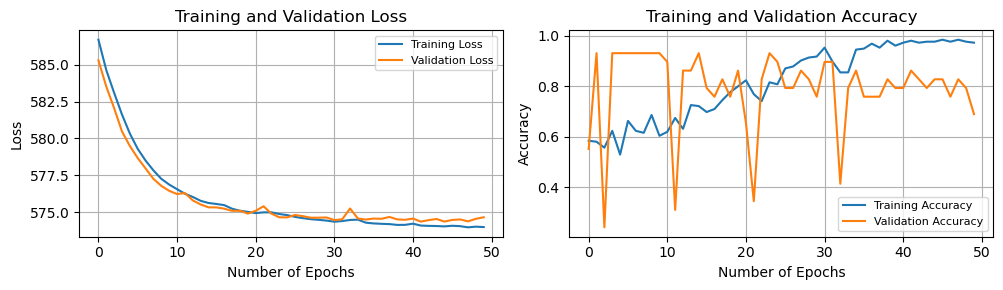

In [13]:
import matplotlib.pyplot as plt

# Training & Validation accuracy
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = len(train_loss)

xc = range(epochs)

plt.figure(figsize=(10, 3))

# Loss subplot
plt.subplot(1, 2, 1)
plt.plot(xc, train_loss, label='Training Loss')
plt.plot(xc, val_loss, label='Validation Loss')
plt.xlabel('Number of Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Training and Validation Loss', fontsize=12)
plt.legend(fontsize=8)
plt.grid(True)

# Accuracy subplot
plt.subplot(1, 2, 2)
plt.plot(xc, train_acc, label='Training Accuracy')
plt.plot(xc, val_acc, label='Validation Accuracy')
plt.xlabel('Number of Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Training and Validation Accuracy', fontsize=12)
plt.legend(fontsize=8, loc='lower right')  # Change position to lower right
plt.grid(True)

plt.tight_layout()
plt.show()


In [13]:
import torch
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support

# Predict on the training dataset
train_predicted = np.argmax(model.predict([X_train, pos_train1, pos_train2]), axis=1)
y_train_to_label = np.argmax(y_train, axis=1)

# Calculate accuracy, precision, recall, and F1-score for the training data
train_accuracy = accuracy_score(y_train_to_label, train_predicted)
train_prec, train_reca, train_fscore, _ = precision_recall_fscore_support(y_train_to_label, train_predicted, average=param)

# Print the classification report for the training data
print("Training Classification Report:")
print(classification_report(y_train_to_label, train_predicted))

# Print the precision, recall, and F1-score for the training data
print("Training Accuracy: {:.2f}%".format(train_accuracy * 100))
print("Training Precision: {:.2f}%".format(train_prec * 100))
print("Training Recall: {:.2f}%".format(train_reca * 100))
print("Training F1 Score: {:.2f}%".format(train_fscore * 100))


Training Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95        89
           1       0.98      0.97      0.98       195

    accuracy                           0.97       284
   macro avg       0.96      0.97      0.96       284
weighted avg       0.97      0.97      0.97       284

Training Accuracy: 96.83%
Training Precision: 98.44%
Training Recall: 96.92%
Training F1 Score: 97.67%


In [14]:
# Load test data from the pickle file
with open('Testpickles/testing_dataLSTM-GRU.pkl', 'rb') as f:
    testing_data = pickle.load(f)

# Extract input features and labels from the test data
X_test = testing_data['X_test']
pos_test1 = testing_data['pos_test1']
pos_test2 = testing_data['pos_test2']
y_test = testing_data['y_test']

# Show the shapes of input features and labels
print("Shape of X_test:", X_test.shape)
print("Shape of pos_test1:", pos_test1.shape)
print("Shape of pos_test2:", pos_test2.shape)
print("Shape of y_test:", y_test.shape)


Shape of X_test: (71, 102)
Shape of pos_test1: (71, 102, 20)
Shape of pos_test2: (71, 102, 20)
Shape of y_test: (71, 2)


In [16]:
predicted = np.argmax(model.predict([X_test,pos_test1,pos_test2]), axis=1)
y_test_to_label= np.argmax(y_test, axis=1)
prec, reca, fscore, sup = precision_recall_fscore_support(y_test_to_label, predicted, average=param)

# Generate the classification report as a dictionary
report_dict = classification_report(y_test_to_label, predicted, output_dict=True)

# Create a new dictionary to hold the formatted values
formatted_report_dict = {}

# Iterate over the items in the report dictionary
for key, value in report_dict.items():
    if isinstance(value, dict):
        # Format the nested dictionary values
        formatted_report_dict[key] = {sub_key: f"{sub_value:.4f}" for sub_key, sub_value in value.items()}
    else:
        # Format the top-level dictionary values
        formatted_report_dict[key] = f"{value:.4f}"

# Create a string representation of the formatted dictionary
formatted_report_str = classification_report(y_test_to_label, predicted, digits=4)

# Print the formatted classification report
print(formatted_report_str)
print(" Precision:{:.2f}% Recall:{:.2f}% Fscore:{:.2f}% ".format(prec*100, reca*100, fscore*100))

              precision    recall  f1-score   support

           0     0.7143    0.8333    0.7692        18
           1     0.9400    0.8868    0.9126        53

    accuracy                         0.8732        71
   macro avg     0.8271    0.8601    0.8409        71
weighted avg     0.8828    0.8732    0.8763        71

 Precision:94.00% Recall:88.68% Fscore:91.26% 


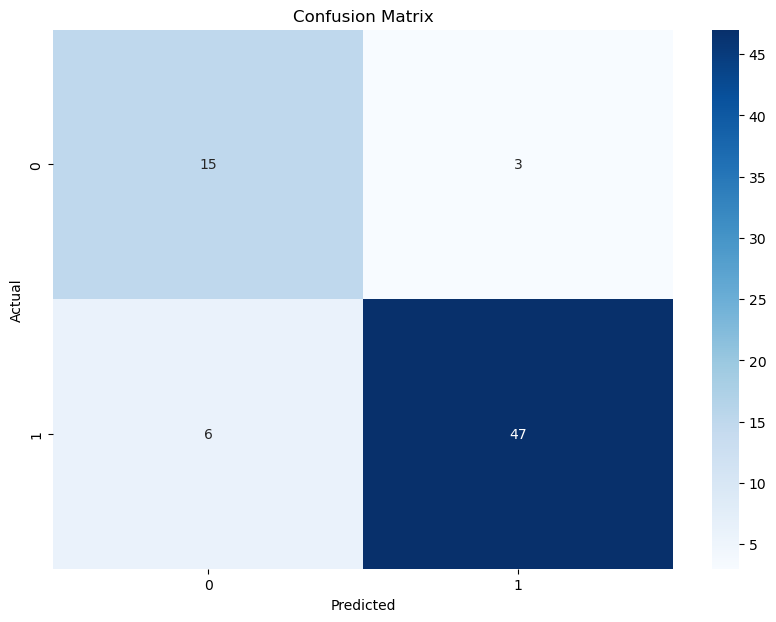

 Precision:94.00% Recall:88.68% Fscore:91.26% 


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold
# Calculate and visualize the confusion matrix
cm = confusion_matrix(y_test_to_label, predicted)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print precision, recall, and f-score
prec, reca, fscore, sup = precision_recall_fscore_support(y_test_to_label, predicted, average=param)
print(" Precision:{:.2f}% Recall:{:.2f}% Fscore:{:.2f}% ".format(prec*100, reca*100, fscore*100))